In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extreme Gradient Boost

[XBOOST](https://xgboost.readthedocs.io/en/stable/)

In [86]:
try:
    import xgboost as xgb
except:
    %pip install xgboost
    import xgboost as xgb

In [87]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_date="data/processed_data/daily_solar_data.feather"


In [88]:
df_enriched_features=pd.read_feather(file_enriched_features)
df_weather_data = pd.read_feather(file_weather_data)
df_solar_data = pd.read_feather(file_solar_date)

In [89]:
print(f'df_enriched_features columns {df_enriched_features.columns.to_list()}')
print(f'df_weather_data {df_weather_data.columns.to_list()}')
print(f'df_solar_data {df_solar_data.columns.to_list()}')

df_enriched_features columns ['DateTime', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date']
df_weather_data ['DateTime', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code']
df_solar_data ['Date', 'Number', 'Time', 'Working State', 'PV(W)', 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)', 'Source_File', 'DateTime']


Convert to hourly date time granularity

This is too see if I can get more accurate readings

In [90]:
# merge all the 3 dataframes on DateTime
df_merge = df_solar_data.merge(right=df_weather_data,how='inner',left_on='DateTime',right_on='DateTime')
df_merge = df_merge.merge(right=df_enriched_features,how='inner',left_on='DateTime',right_on='DateTime')
# convert DateTime to datetime
df_merge['DateTime'] = pd.to_datetime(df_merge['DateTime'])
df_merge['Month_Sin'] = np.sin(2 * np.pi * (df_merge['DateTime'].dt.month - 1) / 12)
df_merge['DayOfYear_Sin'] = np.sin(2 * np.pi * (df_merge['DateTime'].dt.dayofyear - 1) / 365)
df_merge['HourOfDay_Sin'] = np.sin(2 * np.pi * (df_merge['DateTime'].dt.hour) / 24)
print(f"df_merge  {df_merge.columns.to_list()}")
print(f"df_merge  {df_merge.shape}")
# using resample to hourly frequency - depending on the measure either mean or sum
# df_merge  ['Date_x', 'Number', 'Time_x', 'Working State', 'PV(W)', 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)', 'Source_File', 'DateTime', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time_y', 'Date_y', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
# based on the columns column type , solar data columns are summed, weather data temperature and humidity are averaged, enriched features are either summed or first or max
df_merge = df_merge.resample('H', on='DateTime').agg({
    'PV(W)': 'sum',
    'Battery(W)': 'sum',
    'Grid(W)': 'sum',
    'Load(W)': 'sum',
    'Temperature(C)': 'mean',
    'Humidity(%)': 'mean',
    'Solar Radiation(W/m^2)': 'sum',
    'Condition Code': 'max',
    '# Observation period': 'first',
    'TOA': 'mean',
    'Clear sky GHI': 'sum',
    'Clear sky BHI': 'sum',
    'Clear sky DHI': 'sum',
    'Clear sky BNI': 'sum',
    'GHI': 'sum',
    'BHI': 'sum',
    'DHI': 'sum',
    'BNI': 'sum',
    'Reliability,': 'first',
    'Month_Sin': 'first',
    'DayOfYear_Sin': 'first',
    'HourOfDay_Sin': 'first',
    'Date_y': 'first',
    'Date_x': 'first'
}).reset_index()

df_merge  ['Date_x', 'Number', 'Time_x', 'Working State', 'PV(W)', 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)', 'Source_File', 'DateTime', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time_y', 'Date_y', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
df_merge  (59110, 32)


C:\Users\cw171001\AppData\Local\Temp\ipykernel_25396\2761716992.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_merge = df_merge.resample('H', on='DateTime').agg({


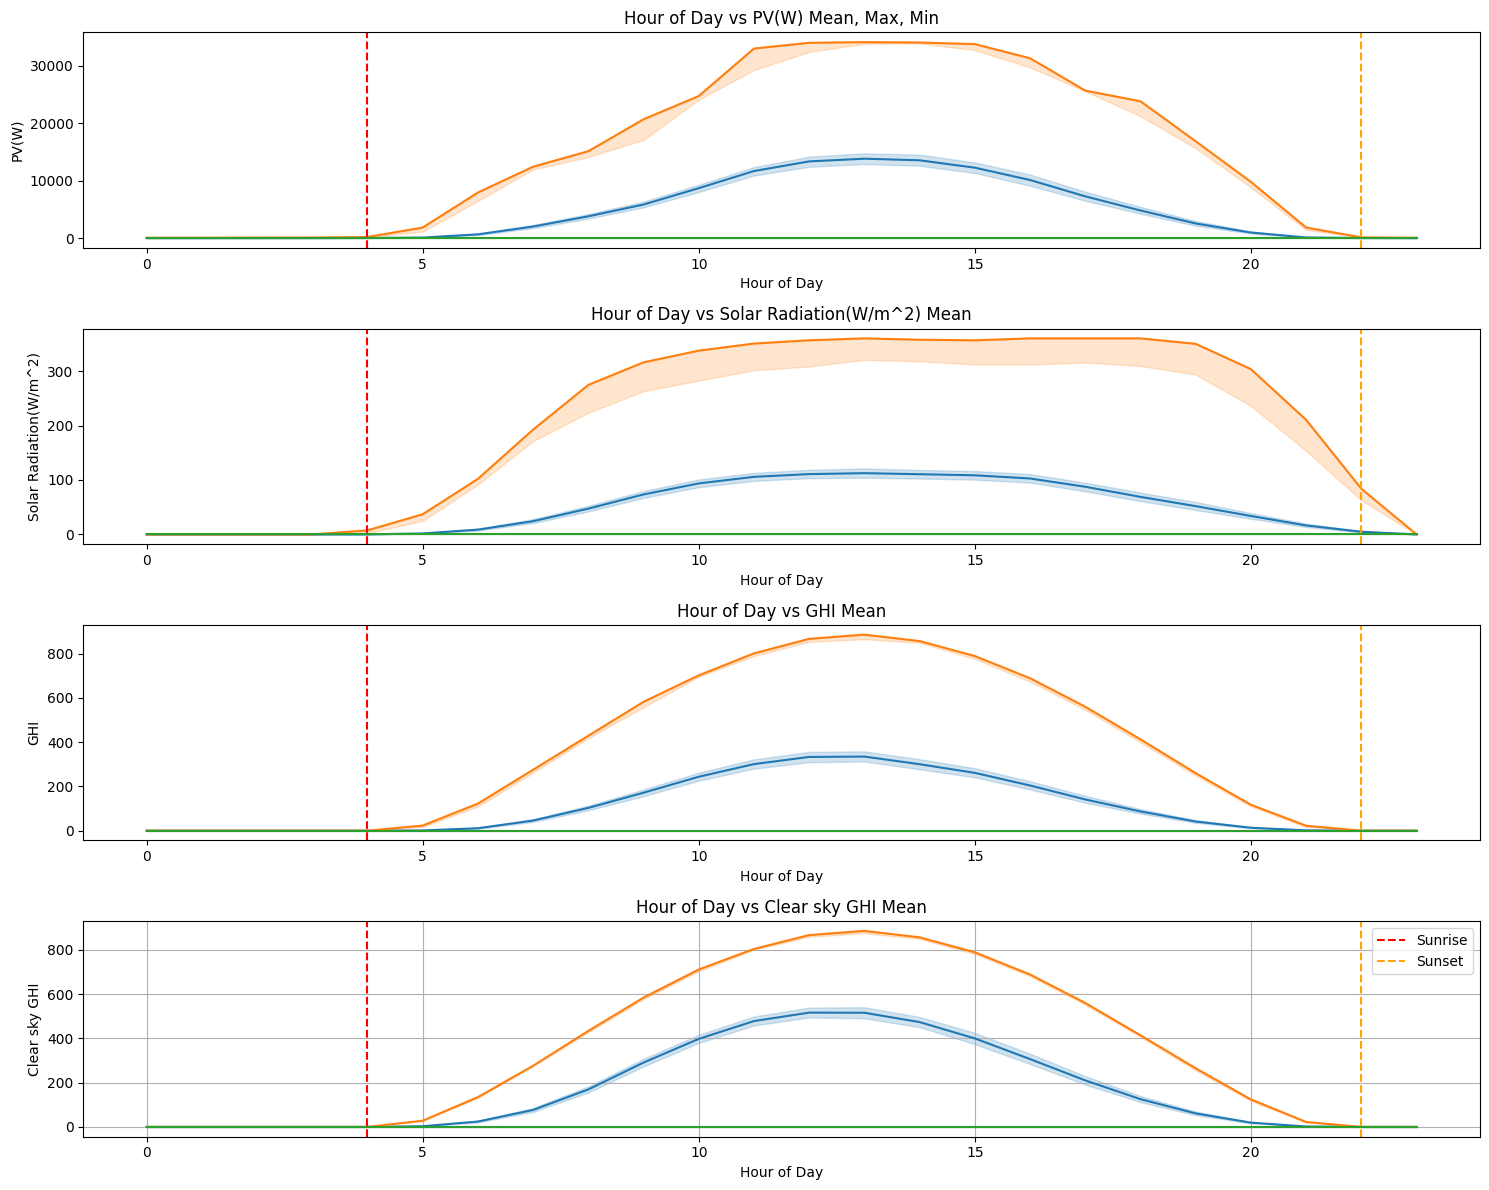

In [91]:
# plot the hour of day vs max , min , mean of PV(W)
fig, ax = plt.subplots(4,1 , figsize=(15 , 12) )
# flatten ax
ax = ax.flatten()
plt.grid()
# plot hour of day vs min, max , mean of PV(W)
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='PV(W)', estimator='mean', ax=ax[0])
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='PV(W)', estimator='max', ax=ax[0])
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='PV(W)', estimator='min', ax=ax[0])
# draw a red vertical line at sunrise and sunset hours (4 and 22)
ax[0].axvline(x=4, color='red', linestyle='--', label='Sunrise')
ax[0].axvline(x=22, color='orange', linestyle='--', label='Sunset')
ax[0].set_title('Hour of Day vs PV(W) Mean, Max, Min')
ax[0].set_xlabel('Hour of Day')
# Same plot for Solar Radiation
ax[1].set_title('Hour of Day vs Solar Radiation(W/m^2) Mean')
ax[1].set_xlabel('Hour of Day')
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='Solar Radiation(W/m^2)', estimator='mean', ax=ax[1])
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='Solar Radiation(W/m^2)', estimator='max', ax=ax[1])
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='Solar Radiation(W/m^2)', estimator='min', ax=ax[1])
# draw a red vertical line at sunrise and sunset hours (4 and 22)
ax[1].axvline(x=4, color='red', linestyle='--', label='Sunrise')
ax[1].axvline(x=22, color='orange', linestyle='--', label='Sunset')
ax[2].set_title('Hour of Day vs GHI Mean')
ax[2].set_xlabel('Hour of Day')
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='GHI', estimator='mean', ax=ax[2])
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='GHI', estimator='max', ax=ax[2])
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='GHI', estimator='min', ax=ax[2])
# draw a red vertical line at sunrise and sunset hours (4 and 22)
ax[2].axvline(x=4, color='red', linestyle='--', label='Sunrise')
ax[2].axvline(x=22, color='orange', linestyle='--', label='Sunset')
ax[3].set_title('Hour of Day vs Clear sky GHI Mean')
ax[3].set_xlabel('Hour of Day')
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='Clear sky GHI', estimator='mean', ax=ax[3])
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='Clear sky GHI', estimator='max', ax=ax[3])
sns.lineplot(data=df_merge, x=df_merge['DateTime'].dt.hour, y='Clear sky GHI', estimator='min', ax=ax[3])
# draw a red vertical line at sunrise and sunset hours (4 and 22)
ax[3].axvline(x=4, color='red', linestyle='--', label='Sunrise')
ax[3].axvline(x=22, color='orange', linestyle='--', label='Sunset')
plt.tight_layout()
plt.legend()
plt.show()# save the merged dataframe


Look at only hours between 4 and 22 

In [92]:
# filter df_merge where DateTime hour is between 4 and 22
df_merge = df_merge[(df_merge['DateTime'].dt.hour >= 4) & (df_merge['DateTime'].dt.hour <= 22) & (df_merge['PV(W)']>20)]
# find the min and max of PV(W) per hour 
df_merge['Hour'] = df_merge['DateTime'].dt.hour
df_merge_hourly_stats = df_merge.groupby('Hour')['PV(W)'].agg(['min', 'max', 'mean']).reset_index()
print(df_merge_hourly_stats)

    Hour    min      max          mean
0      4   21.0    201.0     64.714286
1      5   21.0   1851.0    202.834123
2      6   21.0   7935.0   1063.294776
3      7   22.0  12431.0   2271.113990
4      8  102.0  15123.0   3944.973621
5      9  153.0  20671.0   6089.382212
6     10  187.0  24718.0   9028.532374
7     11  657.0  32975.0  12118.973621
8     12  513.0  33970.0  13863.302158
9     13  340.0  34091.0  14349.225420
10    14  197.0  34025.0  14095.649038
11    15  145.0  33749.0  12758.951923
12    16   25.0  31291.0  10528.418269
13    17   21.0  25665.0   8266.732283
14    18   21.0  23810.0   6703.662379
15    19   21.0  16853.0   4093.703704
16    20   21.0   9795.0   2083.610837
17    21   21.0   1851.0    287.343023
18    22   21.0    141.0     71.143939


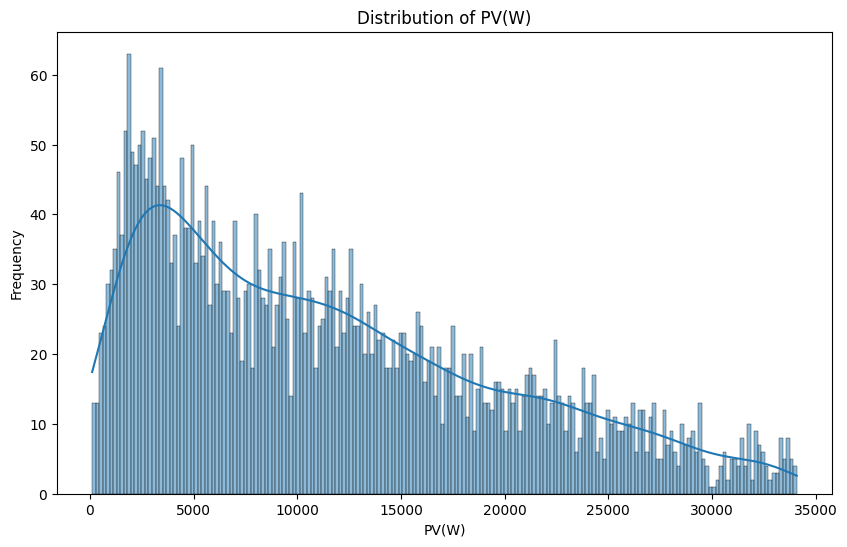

In [110]:
# plot a histogram of the target variable PV(W)
plt.figure(figsize=(10,6))
sns.histplot(df_merge['PV(W)'][df_merge['Clear sky GHI']>100], bins=200, kde=True)
plt.title('Distribution of PV(W)')
plt.xlabel('PV(W)')
plt.ylabel('Frequency')
plt.show()

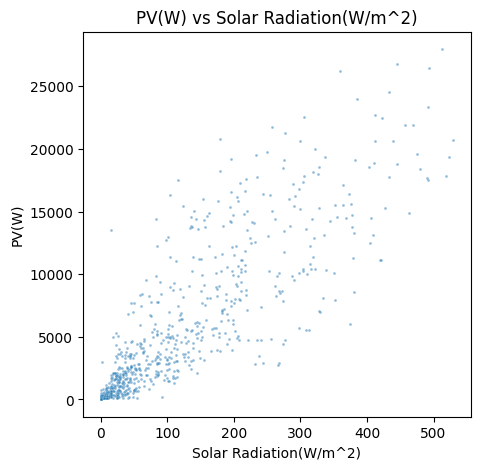

In [111]:
# create a scatter plot of PV(W) vs Solar Radiation(W/m^2)
from datetime import date
plt.figure(figsize=(5,5))
# filter the date range for the scatter plot to be between 2025-01-01 and 2025-01-31 using date type comparison
start_date = date(2025, 1, 1)
end_date = date(2025, 3, 15)
# convert string to date type



sns.scatterplot(x='GHI', y='PV(W)', data=df_merge[(df_merge['Date_y'] >= start_date) & (df_merge['Date_y'] <= end_date)], alpha=0.5, s=4)
plt.title('PV(W) vs Solar Radiation(W/m^2)')
plt.xlabel('Solar Radiation(W/m^2)')
#sns.scatterplot(x='GHI', y='PV(W)', data=df_merge[(df_merge['Date_y'] >= date(2025, 3,14)) & (df_merge['Date_y'] <= date(2025, 8,20))], alpha=0.5, s=4)
#plt.title('PV(W) vs Solar Radiation(W/m^2)')
#plt.xlabel('Solar Radiation(W/m^2)')
#plt.ylabel('PV(W)')
plt.ylabel('PV(W)')
plt.show()

In [113]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Definining Features")
# 1. Define Features (X) and Target (y)
# Dropping 'DateTime' as XGBoost needs numerical inputs, and 'PV(W)' because it's the target
features = ['Temperature(C)', 'Humidity(%)', 'Condition Code',  'DayOfYear_Sin', 'HourOfDay_Sin', 'Clear sky GHI']
target = 'PV(W)'
print("Definining x and y")
X = df_merge[features][df_merge['Clear sky GHI']>100]
y = df_merge[target][df_merge['Clear sky GHI']>100]
print("Splitting")
# 2. Split into Train and Test sets (80% Train, 20% Test)
# random_state ensures reproducibility
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# split by alternative days for time series consistency
X_train = X[df_merge['DateTime'].dt.day % 2 == 0]
X_test = X[df_merge['DateTime'].dt.day % 2 != 0]
y_train = y[df_merge['DateTime'].dt.day % 2 == 0]
y_test = y[df_merge['DateTime'].dt.day % 2 != 0]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Definining Features
Definining x and y
Splitting
Training samples: 1998
Testing samples: 2060


C:\Users\cw171001\AppData\Local\Temp\ipykernel_25396\130502313.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X[df_merge['DateTime'].dt.day % 2 == 0]
C:\Users\cw171001\AppData\Local\Temp\ipykernel_25396\130502313.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = X[df_merge['DateTime'].dt.day % 2 != 0]


In [114]:
# 3. Initialize XGBoost Regressor
# n_estimators: Number of boosting rounds (trees)
# learning_rate: Step size shrinkage used to prevent overfitting
# max_depth: Maximum depth of a tree
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                          n_estimators=100, 
                          learning_rate=0.1, 
                          max_depth=5, 
                          random_state=42,
                      #    enable_categorical=True,  # Tell XGBoost to handle categories
                      #      tree_method='hist'        # 'hist' works best with categorical data
                          )

# 4. Fit the model
print("Training XGBoost model...")
xg_reg.fit(X_train, y_train)
# save model
xg_reg.save_model("solar_xboost.json")
print("Training complete.")

Training XGBoost model...
Training complete.


In [115]:
# 5. Make Predictions
from sklearn.metrics import mean_absolute_percentage_error

y_pred = xg_reg.predict(X_test)

# 6. Evaluate Performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test,y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} W")
print(f"Mean Absolute Error (MAE): {mae:.2f} W")
print(f"Mean Absolute Percentage Error (MAPE) {mape:.2f} %")
# Workk out MAPE


Root Mean Squared Error (RMSE): 4152.54 W
Mean Absolute Error (MAE): 2990.73 W
Mean Absolute Percentage Error (MAPE) 0.48 %


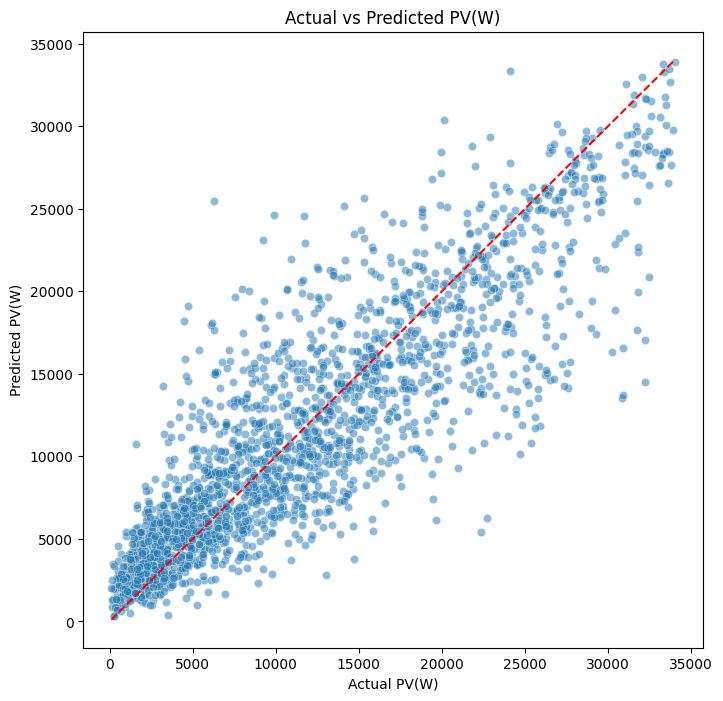

In [116]:
# Plot Actual vs Predicted
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title('Actual vs Predicted PV(W)')
plt.xlabel('Actual PV(W)')
plt.ylabel('Predicted PV(W)')
plt.show()

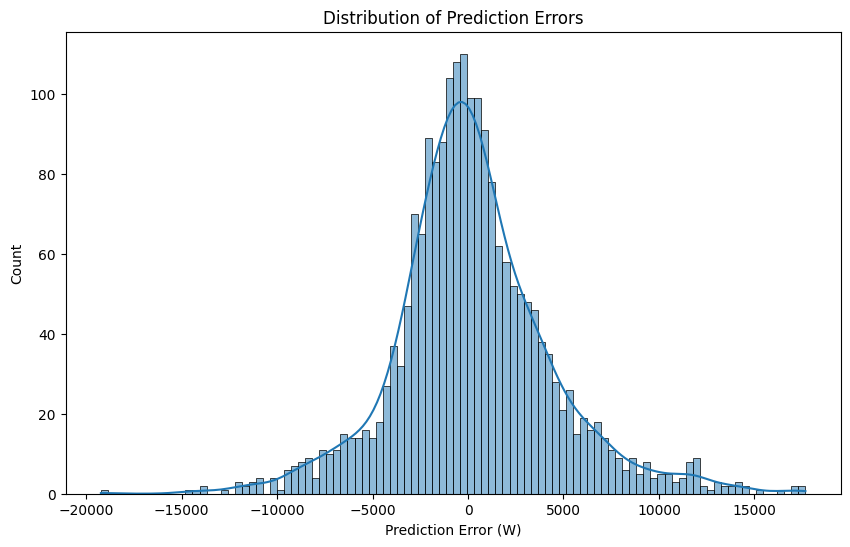

In [117]:
# pot error distribution
errors = y_test - y_pred
plt.figure(figsize=(10,6))
sns.histplot(errors, bins=100, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (W)')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

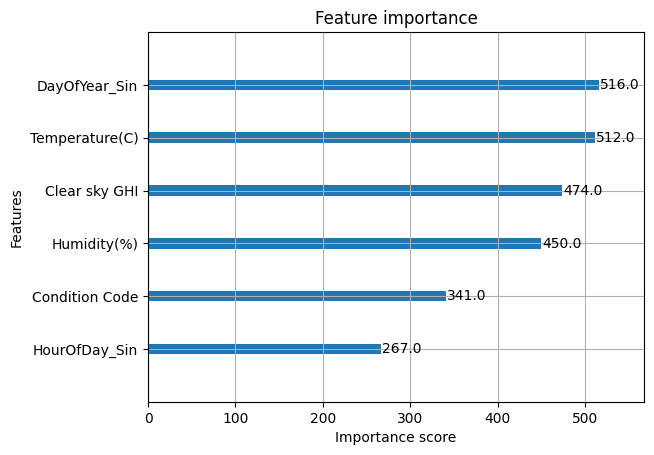

In [118]:
xgb.plot_importance(xg_reg)

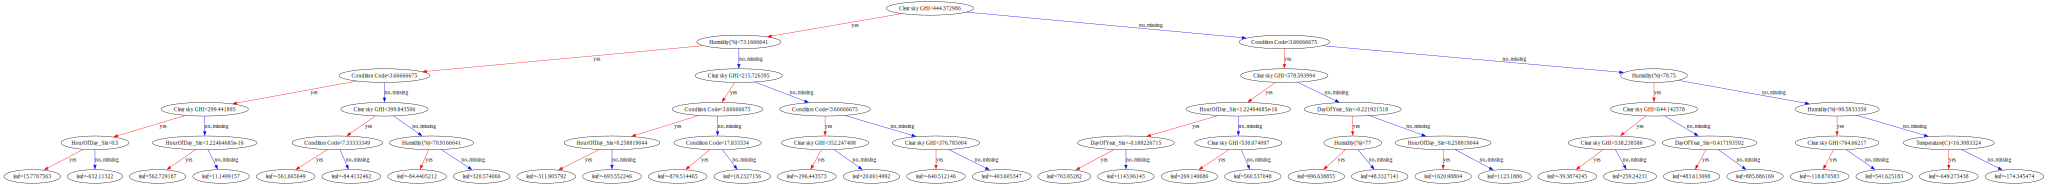

In [119]:
try:
    import graphviz
except: 
    %pip install graphviz
    import graphviz

#xgb.plot_tree(xg_reg)
xgb.to_graphviz(xg_reg)

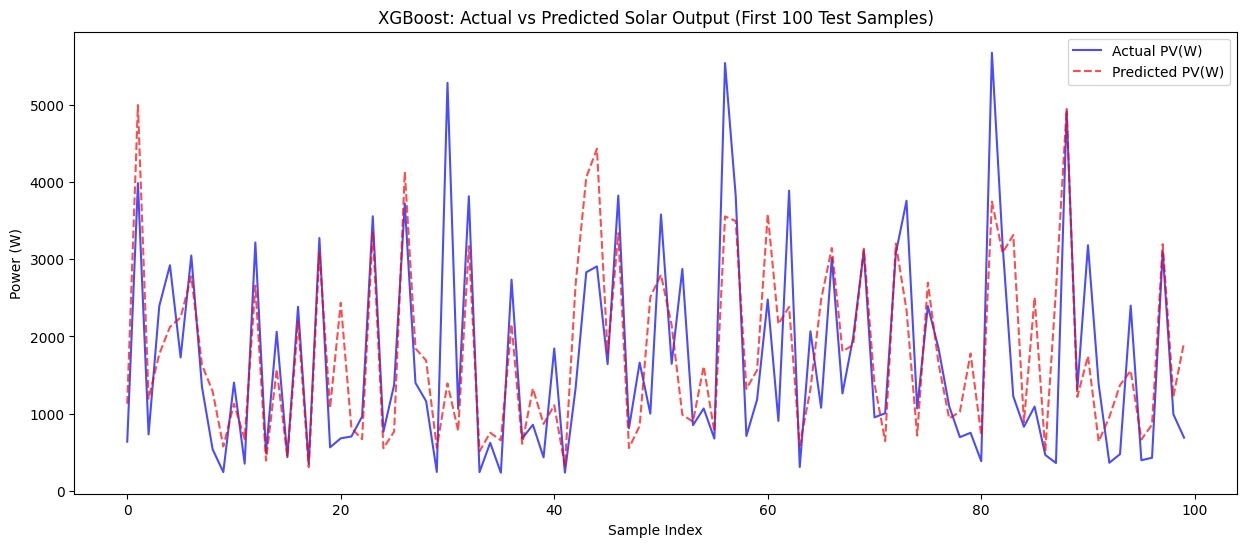

<Figure size 1000x600 with 0 Axes>

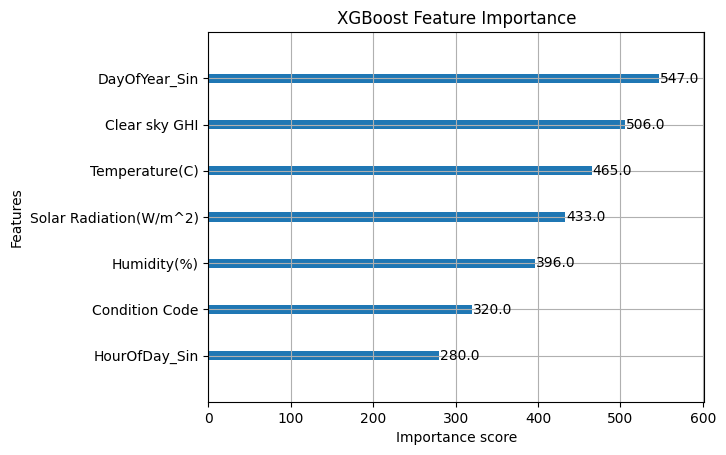

In [21]:


# 7. Visualize Actual vs Predicted (First 100 test points for clarity)
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual PV(W)', color='blue', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted PV(W)', color='red', linestyle='--', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted Solar Output (First 100 Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

# 8. Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(xg_reg, max_num_features=10)
plt.title('XGBoost Feature Importance')
plt.show()

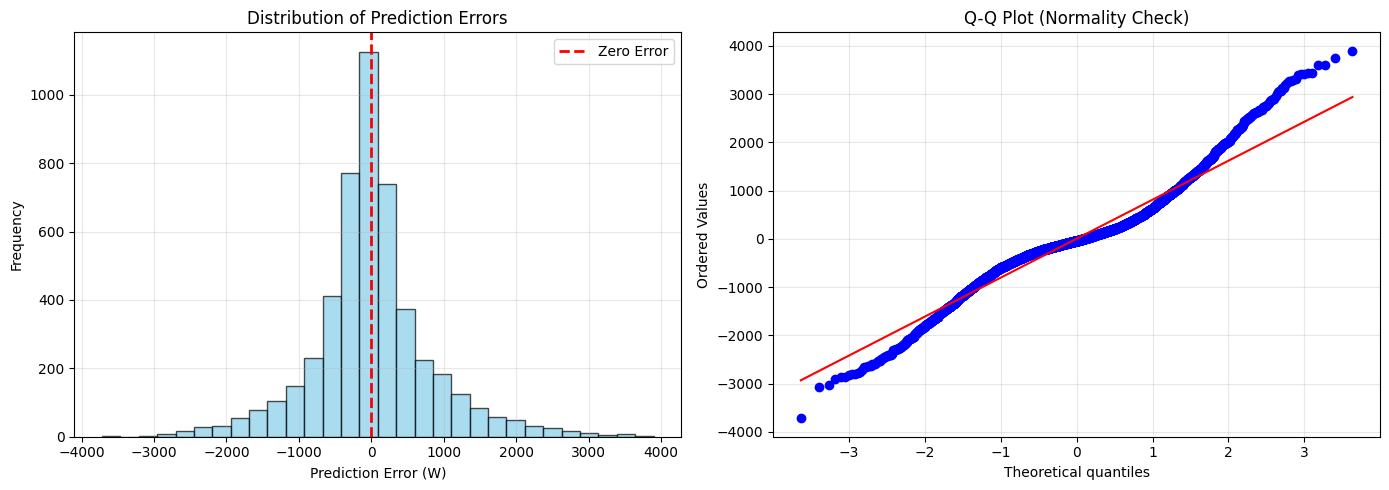

Error Mean: 3.57 W
Error Std Dev: 829.17 W
Error Min: -3719.09 W
Error Max: 3897.91 W


In [22]:
# plot error distribution
# plot error distribution
errors = y_test.values - y_pred

plt.figure(figsize=(14, 5))

# Histogram of errors
plt.subplot(1, 2, 1)
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Prediction Error (W)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.grid(alpha=0.3)

# Q-Q plot for normality check
plt.subplot(1, 2, 2)
from scipy import stats
stats.probplot(errors, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print error statistics
print(f"Error Mean: {errors.mean():.2f} W")
print(f"Error Std Dev: {errors.std():.2f} W")
print(f"Error Min: {errors.min():.2f} W")
print(f"Error Max: {errors.max():.2f} W")